In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets.widgets import interact, FloatSlider
%matplotlib inline

pi = np.pi

plt.rcParams['font.size'] = 40
plt.rcParams['figure.figsize'] = (40, 10)
plt.rcParams['lines.linewidth'] = 2.0

In [2]:
def plot_spectrum(omega, X, T_s, 
                  x_label=r'$\omega/\frac{\pi}{T_\mathrm{s}}$',
                  y_label=r'$X(j\omega)$',
                  x_lim=None):
    plt.figure()
    plt.axhline(c='k', lw=2, alpha=0.75)
    plt.plot(omega*T_s/pi, X, 'b', lw=4)
    plt.axvline(c='k', lw=2, alpha=0.75)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim((min(X)-0.1, max(X)+0.1))
    if x_lim is not None:
        plt.xlim(x_lim)
    plt.grid(True)

In [3]:
def rect(omega, W):
    return (np.abs(omega) < W/2)

In [4]:
def raised_cosine_spectrum(omega, T_s, r):
    def rc_edge(omega, T_s, r):
        return 1/2*(1-np.sin(T_s/(2*r)*(np.abs(omega) - np.pi/T_s)))

    return T_s*(rect(omega, (1-r)*2*np.pi/T_s) + (
        rc_edge(omega, T_s, r)*rect(omega - np.pi/T_s, 2*r*np.pi/T_s) +
        rc_edge(omega, T_s, r)*rect(omega + np.pi/T_s, 2*r*np.pi/T_s)
        if r>0 else omega*0 ))

In [5]:
def root_raised_cosine_spectrum(omega, T_s, r):
    return np.sqrt(raised_cosine_spectrum(**locals()))

# Aufgabe 16: Matched Filter und Root-Raised-Cosine Pulse

Gegeben sei das nachfolgend dargestellte PAM-Übertragungssystem:

![Blockschaltbild](figures/A16/System_Blockdiagramm.png)

Es sei $b(t) = \delta(t)$, $\varphi_{nn}(\tau) = \frac{N_0}{2}\delta(\tau)$ und $\mathrm{E}\left[|A(k)|^2\right] = \sigma_A^2$.    
Berechnen und vergleichen sie das SNR der Entscheidungsvariablen $q(k)$ bei idealer Abtastung für die nachfolgenden drei Fälle.

In [6]:
T_s = 1
omega = np.linspace(-6*np.pi/T_s, 6*np.pi/T_s, 1000)

### Vorbemerkung zur Berechnung des SNR:
Um die Qualität der Übertragung beurteilen zu können, muss das Entscheidungssignal zu den Abtastzeitpunkten betrachtet werden:

\begin{align}
    q(k) = \left. q(t) \right|_{t=kT_\mathrm{s}} &= \left[ s(t) \ast b(t) \ast f(t) + n(t) \ast f(t) \right]_{t=kT_\mathrm{s}} \\
    &= \sum_{m=-\infty}^{\infty} A(m) (g\ast b\ast f)((k - m)T_\mathrm{s}) + (n \ast f)(kT_\mathrm{s}) \\
    &= \sum_{m=-\infty}^{\infty} A(m) p((k - m)T_\mathrm{s}) + n'(kT_\mathrm{s})
\end{align}

Es muss also zunächst das Gesamtfilter bestimmt werden, um den Nutzsignalanteil bewerten zu können.

Das Leistungsdichtespektrum des kontinuierlichen Rauschens ist weiß:

\begin{align}
    \Phi_{nn}(j\omega) = \mathcal{F} \left \{ \varphi_{nn}(\tau) \right\} = \frac{N_0}{2}
\end{align}

Das Leistungsdichtespektrum des Rauschanteils im Entscheidungssignal wird jedoch (nach dem Wiener-Lee-Theorem) zusätzlich vom Empfangsfilter geformt:

\begin{align}
    \Phi_{n'n'}(j\omega) &= \Phi_{nn}(j\omega) \cdot \left|F(j\omega) \right|^2 = \frac{N_0}{2} \cdot \left|F(j\omega) \right|^2
\end{align}

## 16.1:
__Fall 1__: Das Sendefilter sei ein Root-Raised-Cosine-Filter:

\begin{align}
    G_1(j\omega) = 
    \begin{cases}
            \sqrt{T_\mathrm{s}} &\quad:|\omega| < (1-r)\frac{\pi}{T_\mathrm{s}} \\
            \sqrt{\frac{T_\mathrm{s}}{2} \left( 1 -\sin\left( \frac{T_\mathrm{s}}{2 r} \left(|\omega| - \frac{\pi}{T_\mathrm{s}} \right) \right) \right)} & \quad:(1-r)\frac{\pi}{T_\mathrm{s}} < |\omega| < (1+r)\frac{\pi}{T_\mathrm{s}} \\
            0 & \quad:|\omega| > (1+r)\frac{\pi}{T_\mathrm{s}}
    \end{cases}
\end{align}

Für das Empfangsfilter gelte $f_1(t) = g_1(-t)$.

#### Hinweis:

\begin{align}
    \frac{1}{2 \pi} \int_{-\infty}^{\infty} \left|G_1(j\omega)\right|^2 \mathrm{d} \omega = 1
\end{align}

#### Spektrum des Root-Raised-Cosine-Pulses

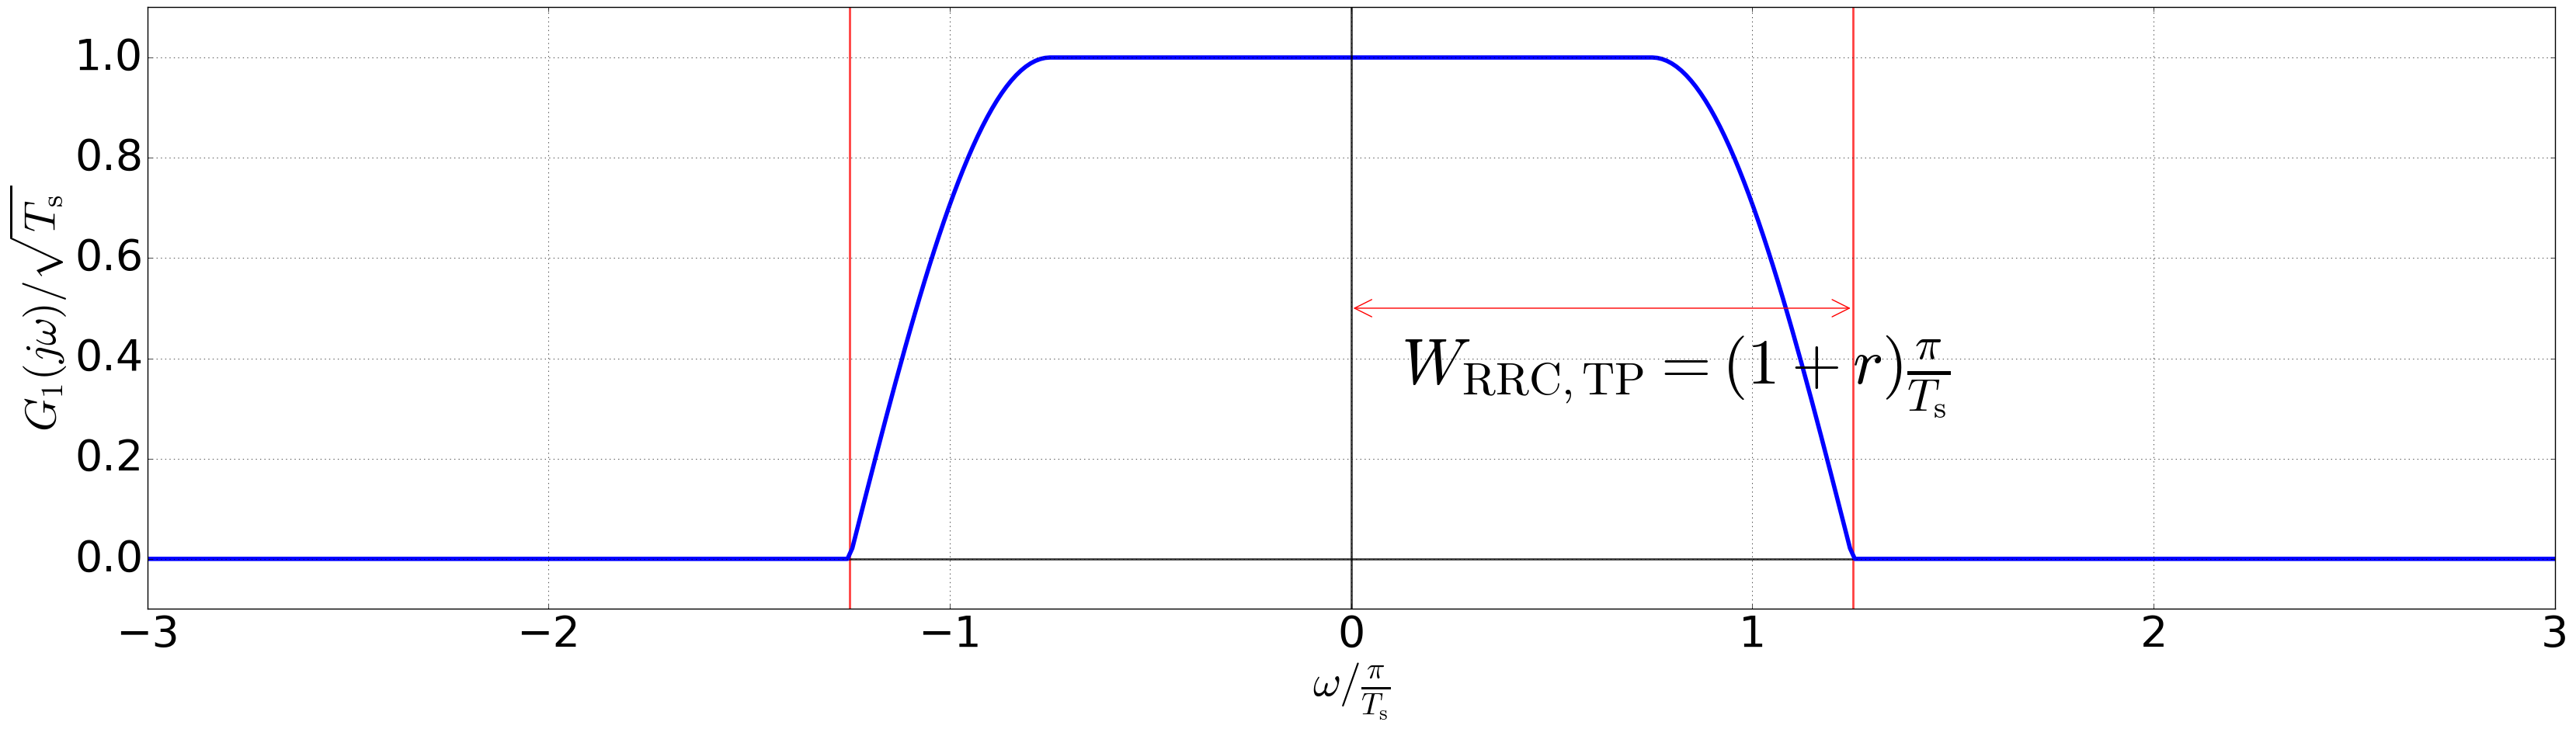

In [7]:
@interact(rolloff=FloatSlider(min=0, max=1, step=0.05, value=0.25))
def plot_rrc_pulse_spectrum(rolloff):
    r = rolloff
    P_w = root_raised_cosine_spectrum(omega, T_s, r)
    plot_spectrum(omega, P_w/T_s, T_s=T_s,
                  y_label=r'$G_1(j\omega)/\sqrt{T_\mathrm{s}}$',
                 x_lim=(-3, 3))

    # Annotationen
    plt.vlines([-(1+r), (1+r)], -1, [2, 2], 'r', alpha=0.75);
    plt.annotate('', (0, 0.5), ((1+r), 0.5),
                 arrowprops={'arrowstyle':'<->','color':'r'});
    plt.text((r+1)/10, 0.35, r'$W_\mathrm{RRC,TP}=(1+r)\frac{\pi}{T_\mathrm{s}}$',
             fontsize=60);

#### Spektrum des Raised-Cosine-Pulses

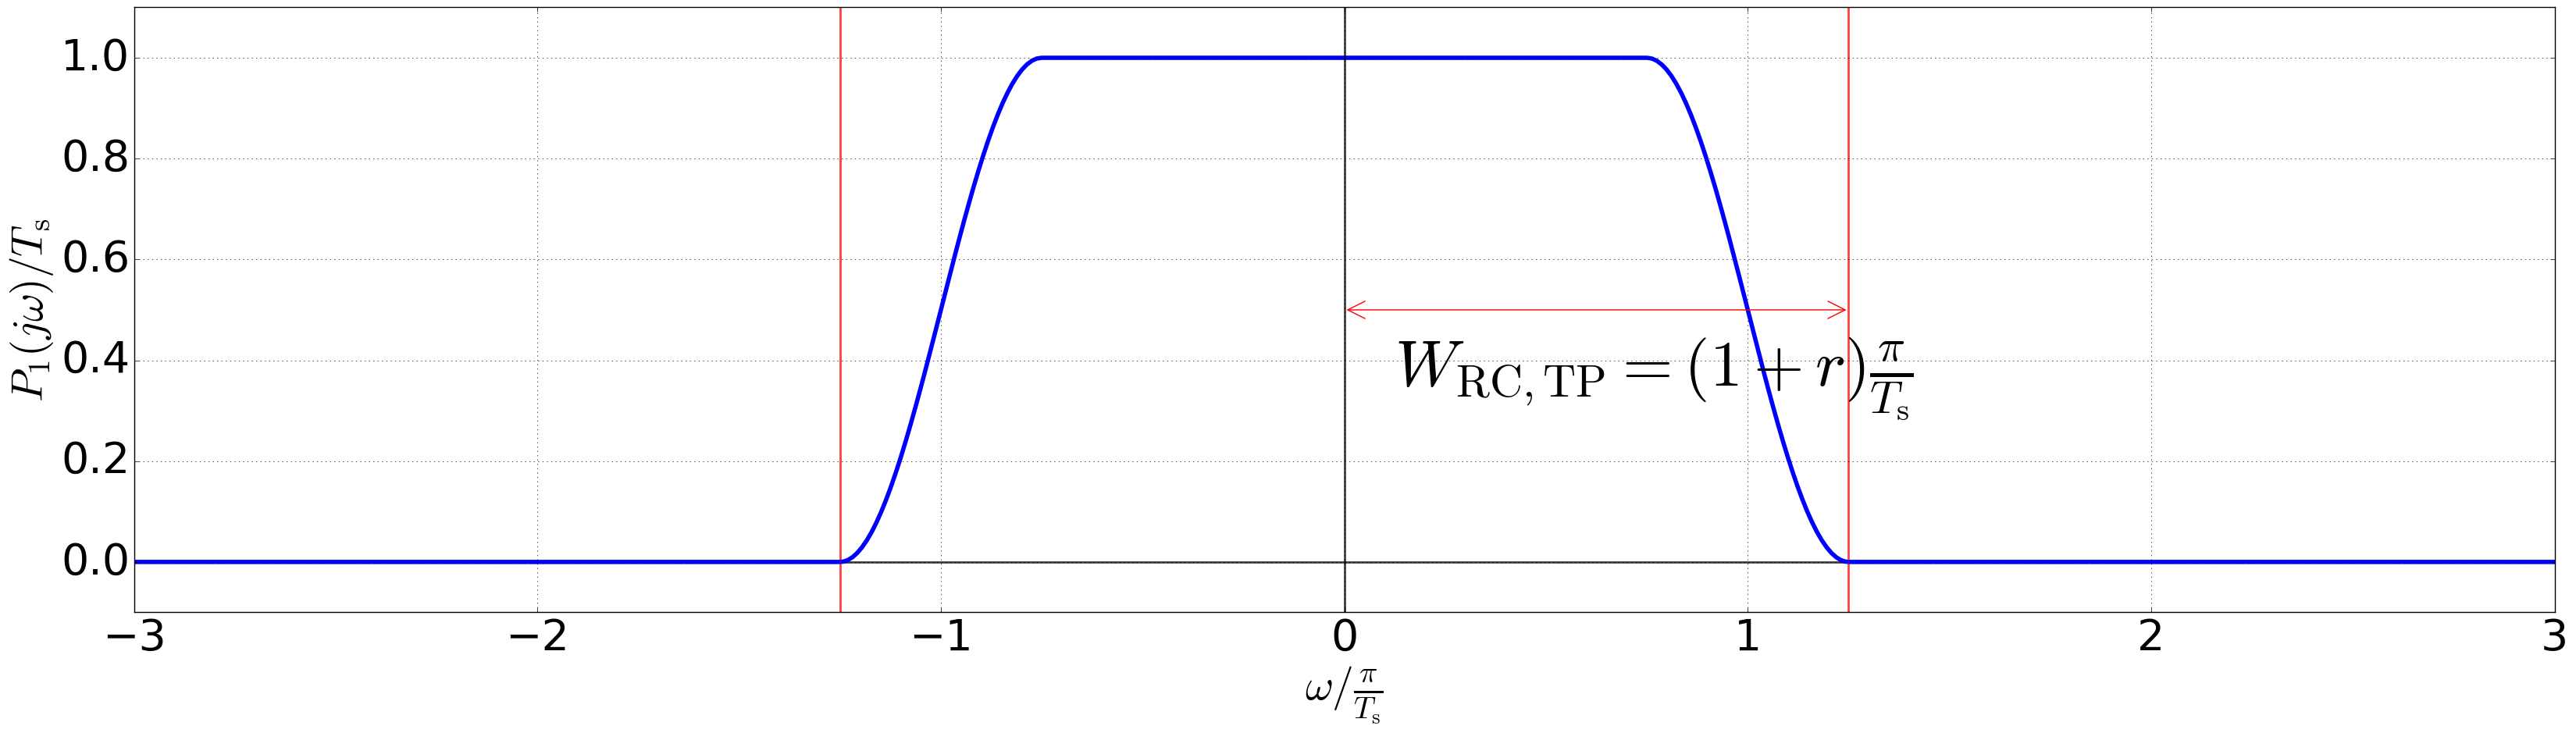

In [8]:
@interact(rolloff=FloatSlider(min=0, max=1, step=0.05, value=0.25))
def plot_rc_pulse_spectrum(rolloff):
    r = rolloff
    P_w = raised_cosine_spectrum(omega, T_s, r)
    plot_spectrum(omega, P_w/T_s, T_s=T_s,
                  y_label=r'$P_1(j\omega)/T_\mathrm{s}$',
                 x_lim=(-3, 3))

    # Annotationen
    plt.vlines([-(1+r), (1+r)], -1, [2, 2], 'r', alpha=0.75);
    plt.annotate('', (0, 0.5), ((1+r), 0.5),
                 arrowprops={'arrowstyle':'<->','color':'r'});
    plt.text((r+1)/10, 0.35, r'$W_\mathrm{RC,TP}=(1+r)\frac{\pi}{T_\mathrm{s}}$',
             fontsize=60);

Wegen $b(t) = 0$ gilt $p_1(t) = g_1(t) \ast f_1(t)$. 
Zusätzlich liegt **Matched-Filterung** vor.
Damit folgt im Frequenzbereich:

\begin{align}
    f_1(t) = g_1(-t) &\Rightarrow F_1(j\omega) = G_1^{\ast}(j\omega) \\
        &\Rightarrow P_1(j\omega) = G_1(j\omega)\cdot F_1(j\omega) = \left|G_1(j\omega)\right|^2
\end{align}

Das Sendefilter hat Root-Raised-Cosine-Charakteristik und erfüllt deshalb allein **nicht das erste Nyquist-Kriterium** (siehe Abbildung). Das **Gesamtfilter hat jedoch Raised-Cosine-Charakteristik** und erfüllt deswegen auch das erste Nyquistkriterium.  Zu den Abtastzeitpunkten hat also nur ein Symbol Einfluss auf den Abtastwert. Wegen der Stationarität der Symbolsequenz reicht es deshalb aus, ein einzelnes Symbol zum Abtastzeitpunkt 0 (dem Maximum des Gesamtpulses) zu betrachten, um die **Leistung des Nutzsignalanteils** zu berechnen:

\begin{align}
    q(k) &= A(0)p_1(0) \\
    \Rightarrow S_{q_1} &= \mathrm{E}\left[ \left|A(0)p_1(0)\right|^2 \right] \\
    &= \mathrm{E}\left[\left|A(0)\right|^2 \right] (p_1(0))^2 \\
    &= \sigma_A^2 \cdot \left(\left. \frac{1}{2 \pi} \int_{-\infty}^{\infty} P_1(j \omega) \mathrm{e}^{j \omega t }\mathrm{d} \omega \right|_{t=0}\right)^2 \\
    &= \sigma_A^2 \cdot \left( \frac{1}{2 \pi} \int_{-\infty}^{\infty} \left|G_1(j\omega)\right|^2 \mathrm{d} \omega \right)^2 \\
    &= \sigma_A^2
\end{align}

Zunächst wurde verwendet, dass sich das Signal an der Stelle Null durch die Fouriertransformation als Integration des Spektrums über alle Frequenzen darstellen lässt.
Im letzten Umformungsschritt wurde zudem der Hinweis ausgenutzt.

Die mittlere Leistung des **Rauschanteils** lässt sich leichter im Frequenzbereich bestimmen, indem die Wiener-Lee-Beziehung ausgenutzt wird:

\begin{align}
    \Phi_{n_1'n_1'}(j\omega) &= \Phi_{nn}(j\omega) \cdot \left|F_1(j\omega) \right|^2 \\
        &= \frac{N_0}{2} \cdot \left|G_1(j\omega) \right|^2 \\[1em]
    \Rightarrow N_{q_1} &= \frac{1}{2 \pi} \int_{-\infty}^{\infty} \Phi_{n'n'}(j\omega) \mathrm{d} \omega \\
    &= \frac{N_0}{2} \cdot \frac{1}{2 \pi} \int_{-\infty}^{\infty} \left|G_1(j\omega) \right|^2 \mathrm{d} \omega \\
    &= \frac{N_0}{2}
\end{align}

Auch hier wurde wieder der Hinweis ausgenutzt.

Damit ergibt sich als SNR:

\begin{align}
    \mathrm{SNR}_1 = \frac{S_{q_1}}{N_{q_1}} = \frac{2 \sigma_A^2}{N_0}
\end{align}

## 16.2:
__Fall 2__: Das Sendefilter sei nun ein Raised-Cosine-Filter:

\begin{align}
    G_2(j\omega) = \frac{1}{\sqrt{T_\mathrm{s}}} \left(G_1(j\omega)\right)^2
\end{align}

Für das Empfangsfilter gelte:
    
\begin{align}
    F_2(j\omega) = \sqrt{T_\mathrm{s}} \mathrm{rect} \left( \frac{\omega}{(1 +r) \frac{2 \pi}{T_\mathrm{s}}} \right).
\end{align}

Das Vorgehen ist analog zum ersten Fall.
Es ergibt sich die gleiche Gesamtpulsform

\begin{align}
    P_2(j\omega) &= G_2(j\omega) F_2(j\omega) \\
        &= \frac{1}{\sqrt{T_\mathrm{s}}} \left(G_1(j\omega)\right)^2 \cdot \sqrt{T_\mathrm{s}} \mathrm{rect} \left( \frac{\omega}{(1 +r) \frac{2 \pi}{T_\mathrm{s}}} \right) \\
        &= \left|G_1(j\omega)\right|^2,
\end{align}

denn das Raised-Cosine-Filter ist nur genau innerhalb der Bandbreite des Empfangsfilters ungleich Null.
Damit wird auch das erste Nypquistkriterium erfüllt und es ergibt sich exakt die gleiche **Leistung des Nutzsignalanteils**:

\begin{align}
    S_{q_2} = S_{q_1} = \sigma_A^2
\end{align}

Die **Leistung des Rauschanteils** wird wieder im Frequenzbereich berechnet:

\begin{align}
    \Phi_{n_2'n_2'}(j\omega) &= \Phi_{nn}(j\omega) \cdot \left|F_2(j\omega) \right|^2 \\
        &= \frac{N_0}{2} \cdot T_\mathrm{s} \mathrm{rect} \left( \frac{\omega}{(1 +r) \frac{2 \pi}{T_\mathrm{s}}} \right) \\[1em]
    \Rightarrow N_{q_2} &= \frac{1}{2 \pi} \int_{-\infty}^{\infty} \Phi_{n'n'}(j\omega) \mathrm{d} \omega \\
    &= \frac{N_0}{2} \cdot \frac{1}{2 \pi} \int_{-\infty}^{\infty} T_\mathrm{s} \mathrm{rect} \left( \frac{\omega}{(1 +r) \frac{2 \pi}{T_\mathrm{s}}} \right) \mathrm{d} \omega \\
    &= \frac{N_0}{2} \cdot \frac{T_\mathrm{s}}{2 \pi} \int_{-(1 +r) \frac{\pi}{T_\mathrm{s}}}^{(1 +r) \frac{\pi}{T_\mathrm{s}}} \mathrm{d} \omega \\
    &= \frac{N_0}{2} \cdot \frac{T_\mathrm{s}}{2 \pi} \cdot (1 +r) \frac{2 \pi}{T_\mathrm{s}} \\
    &= \frac{N_0}{2}\left(1 + r \right)
\end{align}

Weil (vom Sonderfall $r=0$ abgesehen) kein Matched-Filter verwendet wird, ist die Leistung des Rauschanteils im Vergleich zu __Fall 1__ erhöht und das SNR ist abhängig vom Rolloff-Faktor verringert:

\begin{align}
    \mathrm{SNR}_2 = \frac{S_{q_2}}{N_{q_2}} = \frac{2 \sigma_A^2}{N_0 (1 +r)}
\end{align}

Dieses Ergebnis ergibt Sinn: Weil im Gegensatz zu __Fall 1__ keine Matched-Filterung vorliegt, ist das SNR nicht optimal.

## 16.3:
__Fall 3__: Das Sendefilter sei das Gleiche wie in Teilaufgabe 2, für das Empfangsfilter gelte nun aber:

\begin{align}
    f_3(t) = \sqrt{T_\mathrm{s}} \delta(t).
\end{align}

Das Sendefilter ist identisch zu __Fall 2__ und hat Raised-Cosine-Charakteristik. Das Empfangsfilter ändert nichts daran, da die Impulsantwort ein gewichteter Diracimpuls ist. Deshalb kommt dasselbe für die **Leistung des Signalanteils** heraus wie in den vorhergehenden Teilen:

\begin{align}
    S_{q_3} = S_{q_1} = S_{q_2} = \sigma_A^2
\end{align}

Wegen $f_3(t) = \sqrt{T_\mathrm{s}} \delta(t)$ folgt $F_3(j\omega) = T_\mathrm{s}$.

Damit ergibt sich

\begin{align}
    \Phi_{n_3'n_3'}(j\omega) = \Phi_{nn}(j\omega) \cdot \left|F_3(j\omega) \right|^2 = \frac{N_0}{2} T_\mathrm{s},
\end{align}

Es erfolgt also keine Bandbegrenzung des Rauschens. Damit ist $n'(t)$ immer noch ein zeitkontinuierlicher weißer Rauschprozess, hat deshalb **unendliche Leistung** und das Abtasten führt zu unendlichem Aliasing (siehe unten).

Das $\mathrm{SNR}_3$ ist damit unabhängig vom Nutzsignalanteil immer Null.  
Eine Übertragung ohne jegliches Empfangsfilter ist also nicht möglich.

## 16.4:
Für welches Empfangsfilter sind die im Symbolabstand gewonnenen Abtastwerte $q_n(k\cdot T_\mathrm{s})$ des Rauschsignals am Ausgang des Empfangsfilters unkorreliert?

Nach Aufgabenstellung gilt $q_n(k \cdot T_\mathrm{s}) = n'(k \cdot T_\mathrm{s})$.

Die Rauschabtastwerte sind unkorreliert, wenn der Prozess weiß ist, d.h. das Leistungsdichtespektrum (LDS) des diskreten Prozesses konstant ist.
Das LDS eines abgetasteten Zufallsprozesses ergibt sich über die Poissonsche Summenformel aus dem LDS des kontinuierlichen Prozesses:

\begin{align}
    \Phi_{n'n'} \left( \mathrm{e}^{j \omega T_\mathrm{s}} \right) = \frac{1}{T_\mathrm{s}} \sum_{m=-\infty}^{\infty} \Phi_{n'n'} \left( j \left( \omega - m \frac{2 \pi}{T_\mathrm{s}} \right) \right)
\end{align}

* In __Fall 1__ ergibt sich durch das Matched-Filter ein Leistungsdichtespektrum mit Raised-Cosine-Charakteristik, welche das Nyquistkriterium erfüllt: $\Phi_{n_1'n_1'}(j\omega) = \frac{N_0}{2} \cdot \left|G_1(j\omega) \right|^2$.  Darum ist durch die Poisson-Summe auch das LDS des abgetasteten Rauschens konstant, weil gerade mit der richtigen Abtastfrequenz wiederholt wird. Die Abtastwerte sind deshalb unkorreliert.
* In __Fall 2__ ergibt sich ein LDS mit Rechteck-Charakteristik im Frequenzbereich. Jedoch überlappen sich die periodischen Wiederholungen für $r \not \in \{0, 1\}$ teilweise und damit ist das LDS des diskreten Rauschens nicht konstant, die Abtastwerte also auch nicht unkorreliert.
* In __Fall_3__ ist das LDS des kontinuierlichen Prozesses konstant. Die Abtastung führt zu einem Prozess, bei dessen LDS unendlich viele Wiederholungen der Konstanten aufaddiert werden. Das LDS ist demzufolge überall unendlich, damit nicht  definiert und deshalb auch nicht als konstant zu betrachten.

Die **Fälle 1** und **2** sind im Folgenden visualisiert.
In den Plots wurde $T_\mathrm{s} = 1$ und $\frac{N_0}{2} = 4$ gesetzt.

#### Zum Leistungsdichtespektrum bei Fall 1:

Die periodische Wiederholung der Raised-Cosine-Charakteristik ergibt gerade eine Konstante. Dies ist unabhängig vom Rolloff-Faktor:

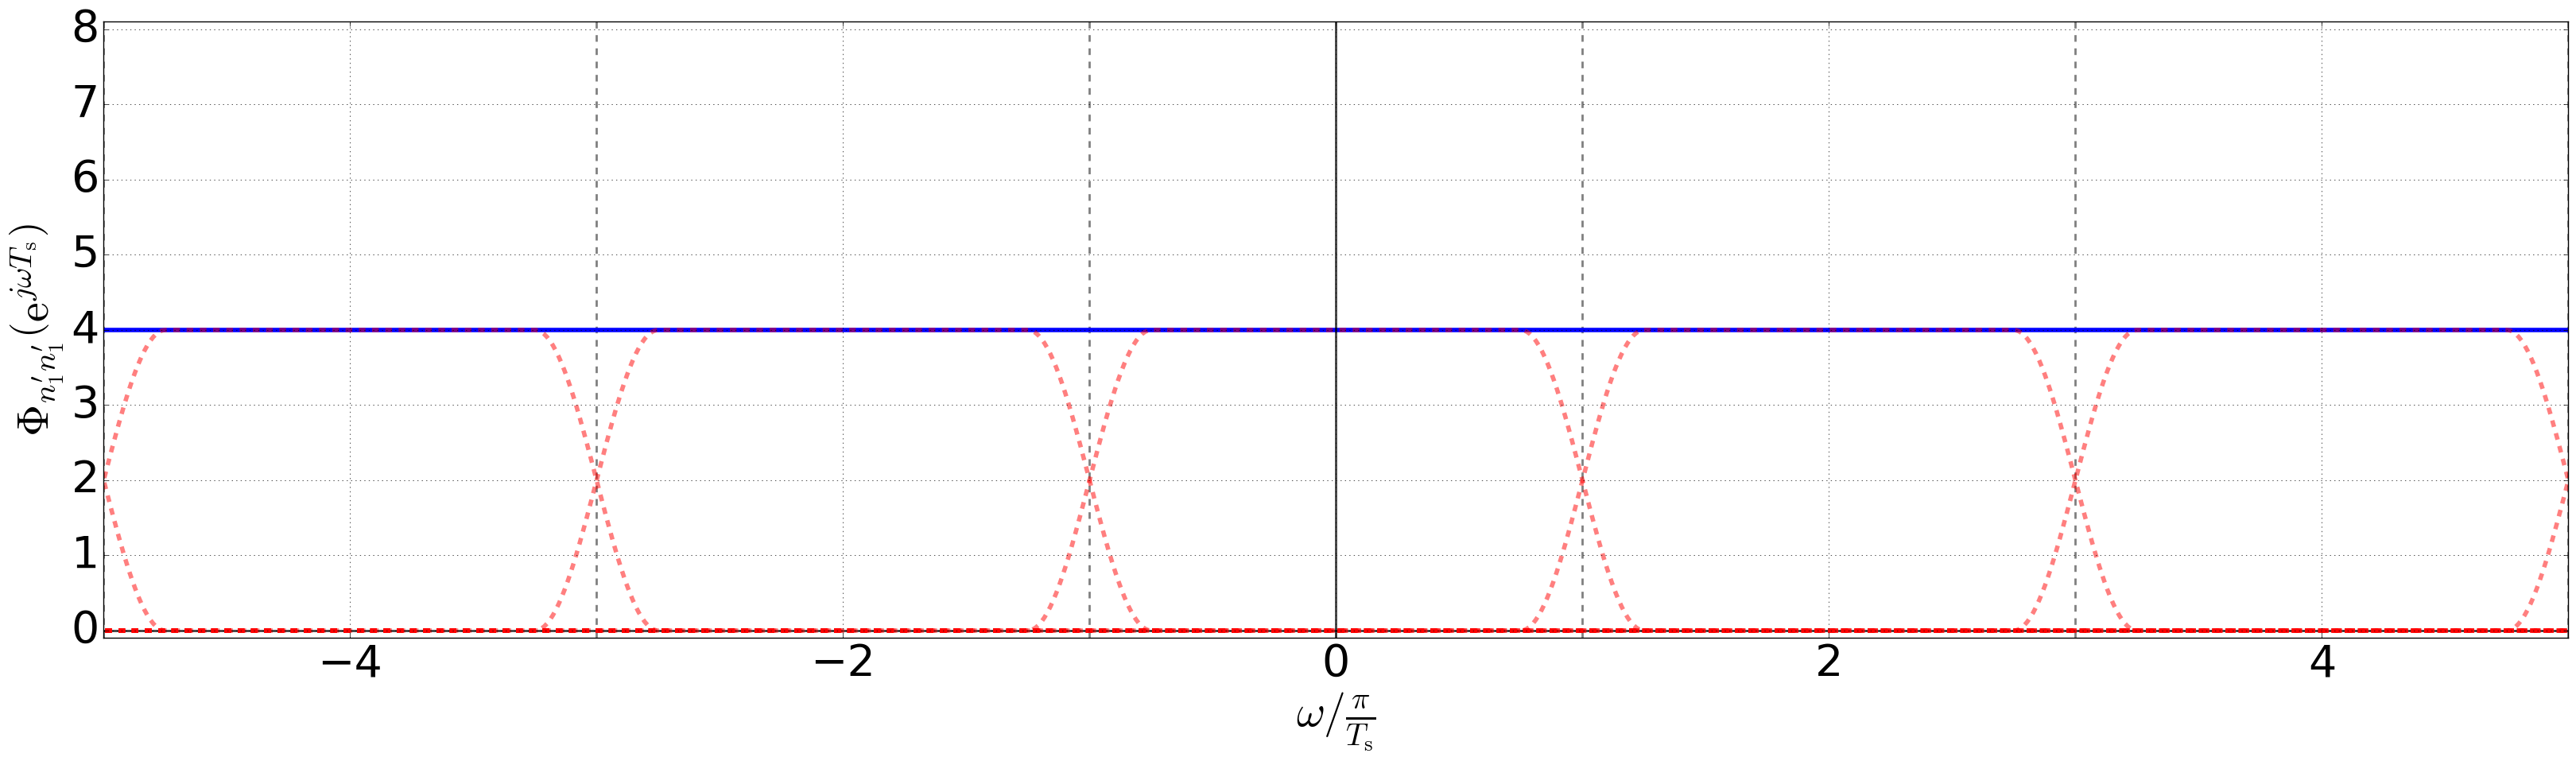

In [9]:
@interact(rolloff=FloatSlider(min=0, max=1, step=0.05, value=0.25))
def plot_poisson_pds_rc(rolloff):
    r = rolloff
    N_0_half = 4
    pds_poisson = np.zeros_like(omega)
    for m in range(-5, 6):
        pds_poisson += N_0_half/T_s*raised_cosine_spectrum(omega -m*2*pi/T_s, T_s, r)
    plot_spectrum(omega, pds_poisson, T_s=T_s,
                  y_label=r"$\Phi_{n_1'n_1'} \left(\mathrm{e}^{j\omega T_\mathrm{s}} \right)$",
                  x_lim=(-5, 5))
    for m in range(-5, 6):
        plt.plot(omega*T_s/np.pi, N_0_half/T_s*raised_cosine_spectrum(omega -m*2*pi/T_s, T_s, r),
                 'r', linestyle='dashed', lw=4, alpha=0.5)
    plt.ylim((-0.1, 8.1))
    plt.vlines(np.r_[-5:6:2], -0.1, 8.1, linestyle='dashed', color='k', lw=2, alpha= 0.5)

#### Zum Leistungsdichtespektrum bei __Fall 2__:

Hier wurde $T_\mathrm{s} = 1$ und $\frac{N_0}{2} = 4$ gesetzt. Dem Plot ist zu entnehmen, dass das LDS des abgetasteten Rauschens offensichtlich nicht konstant ist, wenn $r \not \in \{0, 1\}$ gilt.

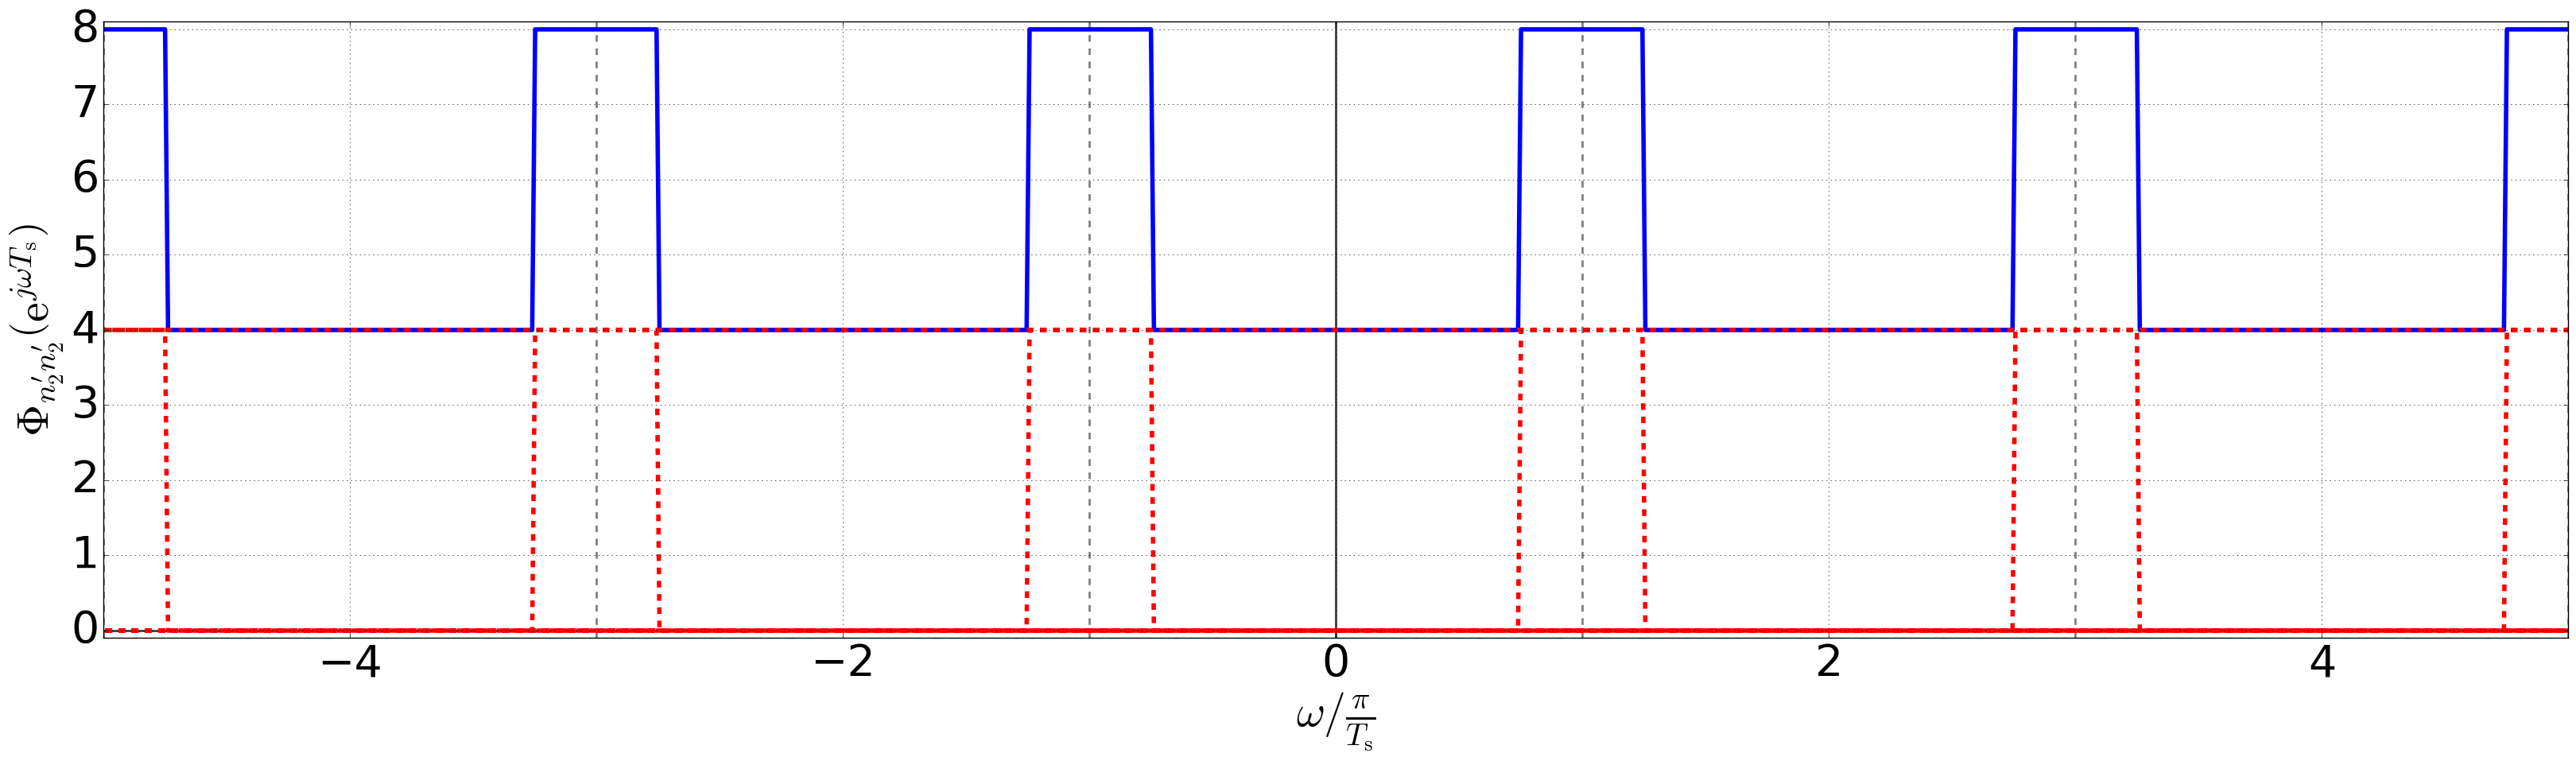

In [10]:
@interact(rolloff=FloatSlider(min=0, max=1, step=0.05, value=0.25))
def plot_poisson_pds_rect(rolloff):
    r = rolloff
    N_0_half = 4
    pds_poisson = np.zeros_like(omega)
    for m in range(-5, 6):
        pds_poisson += N_0_half/T_s*rect(omega -m*2*pi/T_s, 2*pi/T_s*(1+r))
    plot_spectrum(omega, pds_poisson, T_s=T_s,
                  y_label=r"$\Phi_{n_2'n_2'} \left(\mathrm{e}^{j\omega T_\mathrm{s}} \right)$",
                  x_lim=(-5, 5))
    for m in range(-5, 6):
        plt.plot(omega*T_s/np.pi, N_0_half/T_s*rect(omega -m*2*pi/T_s, 2*pi/T_s*(1+r)),
                 'r', lw=4, linestyle='dashed')
    plt.ylim((-0.1, 8.1))
    plt.vlines(np.r_[-5:6:2], -0.1, 8.1, linestyle='dashed', color='k', lw=2, alpha= 0.5)